In [3]:
import torch
import torch.nn as nnp
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
from blitz.modules import ScaleMixturePrior, GaussianVariational
from blitz.modules import BayesianModule
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import pandas as pd
from unidecode import unidecode

from tqdm.notebook import tqdm
from IPython.display import clear_output

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
def MSE(preds, y_true):
    return(np.mean((preds - y_true)**2))

def evaluate_regression(regressor,
                        X,
                        y,
                        samples = 100,
                        std_multiplier = 2):
    preds = [regressor(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    ic_acc = (ci_lower <= y) * (ci_upper >= y)
    ic_acc = ic_acc.float().mean()
    return ic_acc, (ci_upper >= y).float().mean(), (ci_lower <= y).float().mean(), means, stds

def evaluate_regression_mse(regressor,
                            X,
                            y,
                            criterion,
                            samples = 100,
                            std_multiplier = 2):
    preds = [regressor(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    means_mse = criterion(means, y)
    return means_mse

In [7]:
df_raw = pd.read_csv('dane_otodom.csv')
df_raw.shape

(13499, 33)

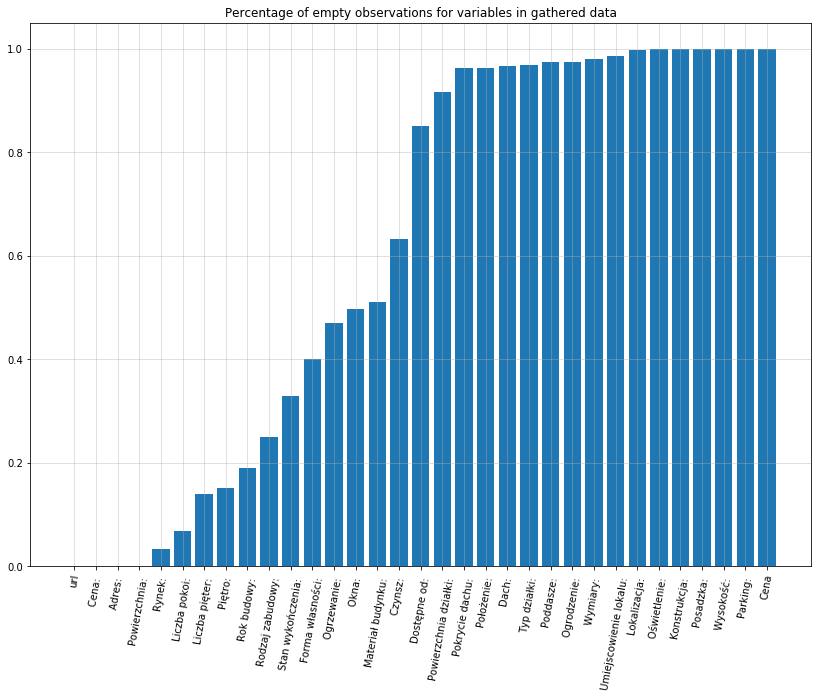

In [8]:
plt.figure(figsize=(14,10))
plt.bar((df_raw.isna().sum().sort_values(ascending=True)/len(df_raw)).index.values, 
        (df_raw.isna().sum().sort_values(ascending=True)/len(df_raw)).values)
plt.grid(alpha=0.5)
plt.xticks(rotation=80)
plt.title('Percentage of empty observations for variables in gathered data')
plt.savefig('nan_variables.png')
plt.show()

<b> Removal of variables with too many missing values: </b>

In [9]:
nans = df_raw.isna().sum()
df_raw_red = df_raw.copy()[(nans[nans<=5000].index)]

<b> Renaming columns and removing rows with at least one missing variable. </b>

In [10]:
df_raw_red.columns = [i.split(':')[0] for i in df_raw_red.columns]
df_raw_red = df_raw_red.copy().dropna(axis=0, how='any')

<b> Removing rows with incorrect values of 'Rok budowy' variable </b>

In [11]:
df_raw_red = df_raw_red.copy()[df_raw_red['Rok budowy'].between(1700., 2022.)]

<b> Extraction of city district from 'Adres' variable, removal of incorrect values in city district, and recategorization of some categories from district variable ('Dzielnica')</b>

In [12]:
df_raw_red['Dzielnica'] = [i.split(',')[1].strip() for i in df_raw_red.Adres]
df_raw_red = df_raw_red.copy()[~df_raw_red['Dzielnica'].isin(['Warszawa', 'mazowieckie'])]
df_raw_red['Dzielnica'] = ['Śródmieście' if i == 'Centrum' else i for i in df_raw_red['Dzielnica']]

<b> Additional cleaning of variables and encoding categorical variables </b>

In [13]:
#cleaning
df_raw_red = df_raw_red.copy()[~df_raw_red['Rodzaj zabudowy'].isin(['plomba', 'loft'])].reset_index(drop=True)
#encoding
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
one_hot_encoder.fit(df_raw_red[['Stan wykończenia', 'Rodzaj zabudowy', 'Rynek', 'Dzielnica']])
encoded_cats = pd.DataFrame(one_hot_encoder.transform(df_raw_red[['Stan wykończenia', 'Rodzaj zabudowy', 'Rynek', 'Dzielnica']]).todense(), columns=one_hot_encoder.get_feature_names(['Stan wykończenia', 'Rodzaj zabudowy', 'Rynek', 'Dzielnica']))
df_raw_red.drop(['Stan wykończenia', 'Rodzaj zabudowy', 'Rynek', 'Dzielnica'], axis=1, inplace=True)
df_raw_red = df_raw_red.merge(encoded_cats, left_index=True, right_index=True)

#further cleaning
price = df_raw_red.Cena.str.replace('zł', '').str.replace(',','.').str.replace(' ', '').apply(unidecode).str.replace(r'Zapytajocene', '0')
price_cln = pd.Series([z * 4.44 if 'EUR' in i else i for i,z in zip(price, price.str.replace('EUR', '').astype('float64'))], index=price.index)
df_raw_red['Cena'] = price_cln.astype('float64')
df_raw_red['Powierzchnia'] = df_raw_red.Powierzchnia.str.split().apply(lambda x: x[0]).str.replace(',','.').astype('float64')

df_raw_red['Liczba pięter'] = df_raw_red['Liczba pięter'].astype('int16')
df_raw_red = df_raw_red.copy()[df_raw_red['Liczba pokoi']!='więcej niż 10']
df_raw_red['Liczba pokoi'] = df_raw_red['Liczba pokoi'].astype('int16')

<b> Cleaned dataset copy </b>

In [14]:
df_cleaned = df_raw_red.copy()[(df_raw_red['Cena']!=0)]
df_model = df_cleaned.copy().drop(['url', 'Adres', 'Piętro'], axis=1)
print(df_model.shape)
df_model.head()

(5878, 33)


,Rok budowy,Cena,Powierzchnia,Liczba pokoi,Liczba pięter,Stan wykończenia_do remontu,Stan wykończenia_do wykończenia,Stan wykończenia_do zamieszkania,Rodzaj zabudowy_apartamentowiec,Rodzaj zabudowy_blok,...,Dzielnica_Targówek,Dzielnica_Ursus,Dzielnica_Ursynów,Dzielnica_Wawer,Dzielnica_Wesoła,Dzielnica_Wilanów,Dzielnica_Wola,Dzielnica_Włochy,Dzielnica_Śródmieście,Dzielnica_Żoliborz
0,2009.0,725000.0,60.4,3,6,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2007.0,530000.0,55.0,2,4,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2007.0,530000.0,55.0,3,4,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1956.0,1490000.0,80.0,3,8,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2019.0,804519.0,73.0,3,5,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Response variable distribution after logarithmic scaling:

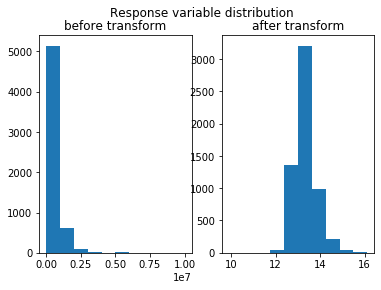

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Response variable distribution')
ax1.hist(df_model.Cena)
ax1.set_title('before transform')
ax2.hist(df_model.Cena.apply(np.log))
ax2.set_title('after transform')
plt.savefig('response_distributions.png')
plt.show()

In [16]:
X = df_model.drop(['Cena'], axis=1).values
y = np.log(df_model['Cena'].values)

x_scaler = MinMaxScaler().fit(X)#StandardScaler().fit(X)#
X_scaled = x_scaler.transform(X)

y_scaler = MinMaxScaler().fit(np.expand_dims(y, -1))#StandardScaler().fit(np.expand_dims(y, -1))##
y_scaled = y_scaler.transform(np.expand_dims(y, -1))

X_trn, X_tst, y_trn, y_tst = train_test_split(X_scaled,
                                                    y_scaled,
                                                    test_size=.25,
                                                    random_state=42)


X_train, y_train = torch.tensor(X_trn).float(), torch.tensor(y_trn).float()
X_test, y_test = torch.tensor(X_tst).float(), torch.tensor(y_tst).float()

<b> Baseline model scores on train and test dataset (Mean Squared Error): </b>

In [17]:
model = LinearRegression()
model.fit(X_trn, y_trn)
np.exp(y_scaler.inverse_transform(np.array([MSE(model.predict(X_trn), y_trn)]).reshape(-1, 1))), np.exp(y_scaler.inverse_transform(np.array([MSE(model.predict(X_tst), y_tst)]).reshape(-1, 1)))

(array([[20129.78118912]]), array([[20135.8766696]]))

<b>First model definition and training </b>

In [197]:
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, prior_pi = 1, prior_sigma1 = 0.1, prior_sigma2 = 0.001):
        super().__init__()
        self.blinear1 = BayesianLinear(input_dim, 256, prior_pi = prior_pi, prior_sigma_1 = prior_sigma1, prior_sigma_2 = prior_sigma2)
        self.relu1 = nn.ReLU()
        self.blinear2 = BayesianLinear(256, output_dim, prior_pi = prior_pi, prior_sigma_1 = prior_sigma1, prior_sigma_2 = prior_sigma2)
        
    def forward(self, x):
        x = self.blinear1(x)
        x = self.relu1(x)
        return self.blinear2(x)

In [199]:
device = torch.device('cpu')

regressor = BayesianRegressor(32, 1, prior_pi = 0.5, prior_sigma1 = 0.1, prior_sigma2 = 0.01)
regressor = regressor.to(device)

optimizer = optim.Adam(regressor.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()


ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=256, shuffle=True)

best_loss = 1e5

#for further diagnostics
epochs=[]
accs=[]
uppers=[]
lowers=[]
losses=[]
means = []
stds = []

#training loop
n_epochs = 1000
for epoch in tqdm(range(n_epochs)):
    #training
    epoch_losses = []
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = regressor.sample_elbo(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=10,
                           complexity_cost_weight=1/X_train.shape[0])
        
        if str(loss.item()) == 'nan':
            raise ValueError(f'loss in trainig loop of epoch {epoch} went to nan - check parameters')
            
        loss.backward()
        
        optimizer.step()

        
        epoch_losses.append(loss.cpu().detach().item())
    mean_loss = np.mean(epoch_losses)
        
    #test evaluation
    with torch.no_grad():
        ic_acc, under_ci_upper, over_ci_lower, mean, std = evaluate_regression(regressor,
                                                                                X_test.to(device),
                                                                                y_test.to(device),
                                                                                samples=25,
                                                                                std_multiplier=1)

        epochs.append(epoch)
        accs.append(ic_acc)
        uppers.append(under_ci_upper)
        lowers.append(over_ci_lower)
        losses.append(mean_loss)
        means.append(mean.cpu().numpy())
        stds.append(std.cpu().numpy())
        if epoch % 50 == 0:
            print("\nEpoch: ", epoch, 'statistics')     
            print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
            print("Loss: {:.4f}".format(mean_loss))
        
    if (mean_loss < best_loss):
        best_loss = mean_loss
        best_epoch1 = epoch
        torch.save(regressor, 'best_model1.bin')
print(f'Best model found at epoch {best_epoch2}, best loss: {best_loss}')


Epoch:  0 statistics
CI acc: 0.00, CI upper acc: 1.00, CI lower acc: 0.00
Loss: 0.9195


C:\Users\rafal.wojcik\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BayesianRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


ValueError: loss in trainig loop of epoch 14 went to nan - check parameters

<b> First models' scores </b>

In [200]:
%%time
device = torch.device('cpu')
best_model = torch.load('best_model1.bin')
best_model = best_model.to(device)

mse_trn = evaluate_regression_mse(best_model, X_train.to(device), y_train.to(device), criterion, samples=10)
mse_test = evaluate_regression_mse(best_model, X_test.to(device), y_test.to(device), criterion, samples=10)
np.exp(y_scaler.inverse_transform(np.array([mse_trn]).reshape(-1,1))), np.exp(y_scaler.inverse_transform(np.array([mse_test]).reshape(-1,1)))

Wall time: 94 ms


(array([[20151.27201606]]), array([[20160.95151416]]))

<b> Second model definition and training </b>

In [202]:
device = torch.device('cpu')

regressor2 = BayesianRegressor(32, 1, prior_pi = 0.5, prior_sigma1 = 1., prior_sigma2 = 0.5)
regressor2 = regressor2.to(device)

optimizer = optim.Adam(regressor2.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()


ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=256, shuffle=True)

best_loss = 1e5
best_acc = 0.

#for further diagnostics
epochs=[]
accs=[]
uppers=[]
lowers=[]
losses=[]
means = []
stds = []

#training loop
n_epochs = 1000
for epoch in tqdm(range(n_epochs)):
    #training
    epoch_losses = []
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = regressor2.sample_elbo(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=10,
                           complexity_cost_weight=1/X_train.shape[0])
        
        if str(loss.item()) == 'nan':
            raise ValueError('loss in trainig loop of epoch {epoch} went to nan - check parameters')
            
        loss.backward()
        
        optimizer.step()

        
        epoch_losses.append(loss.cpu().detach().item())
    mean_loss = np.mean(epoch_losses)
        
    #test evaluation
    with torch.no_grad():
        ic_acc, under_ci_upper, over_ci_lower, mean, std = evaluate_regression(regressor2,
                                                                                X_test.to(device),
                                                                                y_test.to(device),
                                                                                samples=25,
                                                                                std_multiplier=1)

        epochs.append(epoch)
        accs.append(ic_acc)
        uppers.append(under_ci_upper)
        lowers.append(over_ci_lower)
        losses.append(mean_loss)
        means.append(mean.numpy())
        stds.append(std.numpy())
        if epoch % 50 == 0:
            print("\nEpoch: ", epoch, 'statistics')     
            print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
            print("Loss: {:.4f}".format(mean_loss))
        
    if mean_loss < best_loss:
        best_acc = ic_acc
        best_loss = mean_loss
        best_epoch2 = epoch
        torch.save(regressor2, 'best_model2.bin')
print(f'Best model found at epoch {best_epoch2}, best loss: {best_loss}')


Epoch:  0 statistics
CI acc: 0.00, CI upper acc: 1.00, CI lower acc: 0.01
Loss: 0.0175


C:\Users\rafal.wojcik\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BayesianRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Epoch:  50 statistics
CI acc: 0.41, CI upper acc: 0.70, CI lower acc: 0.71
Loss: 0.0005

Epoch:  100 statistics
CI acc: 0.20, CI upper acc: 0.24, CI lower acc: 0.96
Loss: 0.0004

Epoch:  150 statistics
CI acc: 0.29, CI upper acc: 0.90, CI lower acc: 0.39
Loss: 0.0004

Epoch:  200 statistics
CI acc: 0.29, CI upper acc: 0.38, CI lower acc: 0.92
Loss: 0.0004

Epoch:  250 statistics
CI acc: 0.35, CI upper acc: 0.44, CI lower acc: 0.91
Loss: 0.0003

Epoch:  300 statistics
CI acc: 0.43, CI upper acc: 0.49, CI lower acc: 0.94
Loss: 0.0003

Epoch:  350 statistics
CI acc: 0.29, CI upper acc: 0.38, CI lower acc: 0.91
Loss: 0.0003

Epoch:  400 statistics
CI acc: 0.38, CI upper acc: 0.84, CI lower acc: 0.54
Loss: 0.0002

Epoch:  450 statistics
CI acc: 0.44, CI upper acc: 0.81, CI lower acc: 0.64
Loss: 0.0002

Epoch:  500 statistics
CI acc: 0.43, CI upper acc: 0.67, CI lower acc: 0.76
Loss: 0.0002

Epoch:  550 statistics
CI acc: 0.34, CI upper acc: 0.79, CI lower acc: 0.55
Loss: 0.0002

Epoch:  60

In [203]:
%%time
device = torch.device('cpu')
best_model = torch.load('best_model2.bin')
best_model = best_model.to(device)

mse_trn = evaluate_regression_mse(best_model, X_train.to(device), y_train.to(device), criterion, samples=200)
mse_test = evaluate_regression_mse(best_model, X_test.to(device), y_test.to(device), criterion, samples=200)
np.exp(y_scaler.inverse_transform(np.array([mse_trn]).reshape(-1,1))), np.exp(y_scaler.inverse_transform(np.array([mse_test]).reshape(-1,1)))

Wall time: 1.59 s


(array([[20074.94142806]]), array([[20095.76501672]]))

<b> Plotting mean predictions shifts during training of best model</b>

for 50 lowest prices

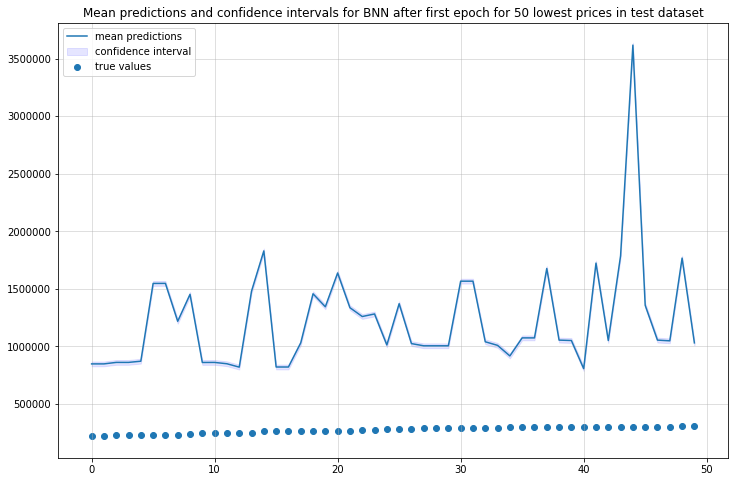

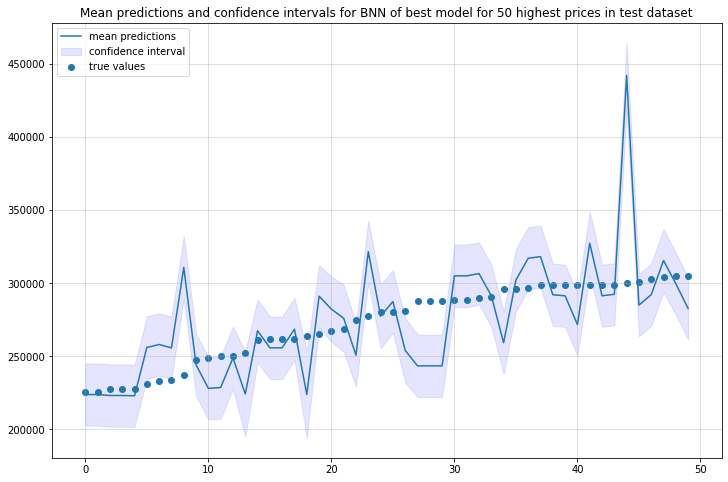

In [206]:
predictions_df = pd.DataFrame([y_test.numpy().squeeze(), means[0].squeeze(), stds[0].squeeze(), means[best_epoch2].squeeze(), stds[best_epoch2].squeeze()],
                              index = ['true_values', 'means_first', 'stds_first', 'means_last', 'stds_last']).T.sort_values('true_values').reset_index(drop=True).iloc[:50]#.iloc[-50:]

predictions_df = predictions_df.copy().apply(lambda x: list(map(lambda y: np.exp(y_scaler.inverse_transform(np.array([y]).reshape(-1, 1))[0][0]), x)), axis=0)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(predictions_df.index, predictions_df.means_first, label='mean predictions')
ax.fill_between(predictions_df.index, (predictions_df.means_first - predictions_df.stds_first), (predictions_df.means_first + predictions_df.stds_first), color='b', alpha=.1, label='confidence interval')
ax.scatter(predictions_df.index, predictions_df.true_values, label='true values')
ax.grid(alpha=0.5)
ax.legend()
ax.set_title("Mean predictions and confidence intervals for BNN after first epoch for 50 lowest prices in test dataset")
plt.savefig('first_epoch_first_50.png')
plt.show()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(predictions_df.index, predictions_df.means_last, label='mean predictions')
ax.fill_between(predictions_df.index, (predictions_df.means_last - predictions_df.stds_last), (predictions_df.means_last + predictions_df.stds_last), color='b', alpha=.1, label='confidence interval')
ax.scatter(predictions_df.index, predictions_df.true_values, label='true values')
ax.grid(alpha=0.5)
ax.legend()
ax.set_title("Mean predictions and confidence intervals for BNN of best model for 50 highest prices in test dataset")
plt.savefig('best_epoch_first_50.png')
plt.show()

for 50 highest prices

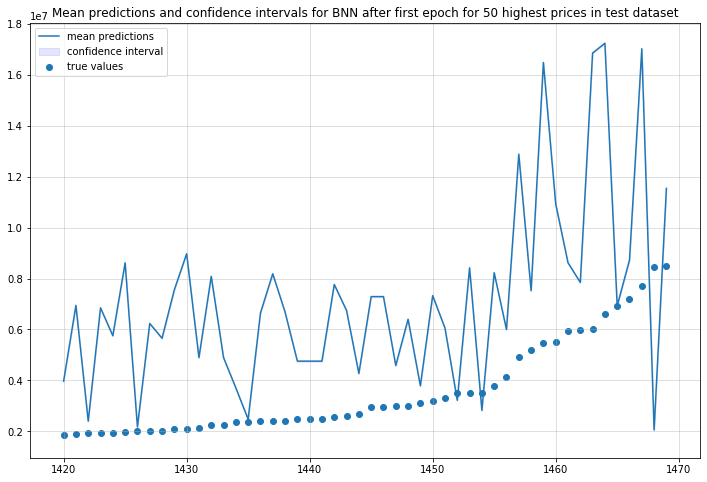

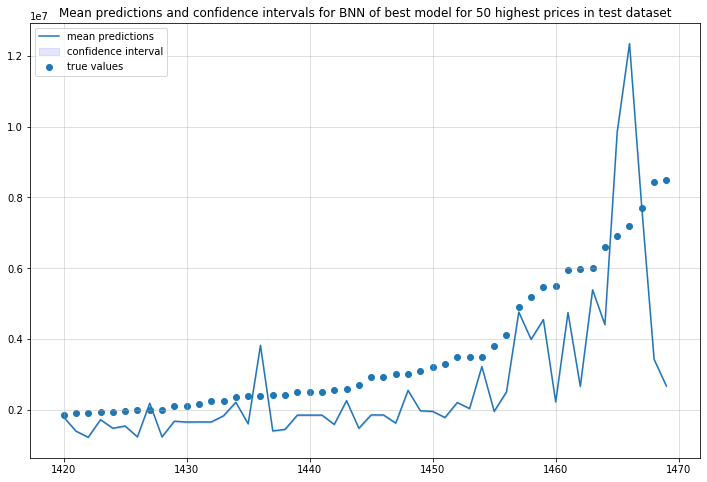

In [205]:
predictions_df = pd.DataFrame([y_test.numpy().squeeze(), means[0].squeeze(), stds[0].squeeze(), means[best_epoch2].squeeze(), stds[best_epoch2].squeeze()],
                              index = ['true_values', 'means_first', 'stds_first', 'means_last', 'stds_last']).T.sort_values('true_values').reset_index(drop=True).iloc[-50:]

predictions_df = predictions_df.copy().apply(lambda x: list(map(lambda y: np.exp(y_scaler.inverse_transform(np.array([y]).reshape(-1, 1)))[0][0], x)), axis=0)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(predictions_df.index, predictions_df.means_first, label='mean predictions')
ax.fill_between(predictions_df.index, (predictions_df.means_first - predictions_df.stds_first), (predictions_df.means_first + predictions_df.stds_first), color='b', alpha=.1, label='confidence interval')
ax.scatter(predictions_df.index, predictions_df.true_values, label='true values')
ax.grid(alpha=0.5)
ax.legend()
ax.set_title("Mean predictions and confidence intervals for BNN after first epoch for 50 highest prices in test dataset")
plt.savefig('first_epoch_last_50.png')
plt.show()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(predictions_df.index, predictions_df.means_last, label='mean predictions')
ax.fill_between(predictions_df.index, (predictions_df.means_last - predictions_df.stds_last), (predictions_df.means_last + predictions_df.stds_last), color='b', alpha=.1, label='confidence interval')
ax.scatter(predictions_df.index, predictions_df.true_values, label='true values')
ax.grid(alpha=0.5)
ax.legend()
ax.set_title("Mean predictions and confidence intervals for BNN of best model for 50 highest prices in test dataset")
plt.savefig('best_epoch_last_50.png')
plt.show()